In [1]:
import pandas as pd
import tensorflow as tf
import keras
from keras import layers as ls
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, VotingClassifier
import seaborn as sns
from scipy import stats
import xgboost as xgb
import joblib

In [2]:
df = pd.read_csv("forestfires.csv")
df.columns

Index(['X', 'Y', 'month', 'day', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH',
       'wind', 'rain', 'area'],
      dtype='object')

In [3]:
# Mapping of days to numeric values
day_mapping = {
    'mon': 1,
    'tue': 2,
    'wed': 3,
    'thu': 4,
    'fri': 5,
    'sat': 6,
    'sun': 7
}

# Map the days to numeric values
df['day'] = df['day'].map(day_mapping)

In [4]:
df['TempAndFFMC'] = df['temp'] / df['FFMC']

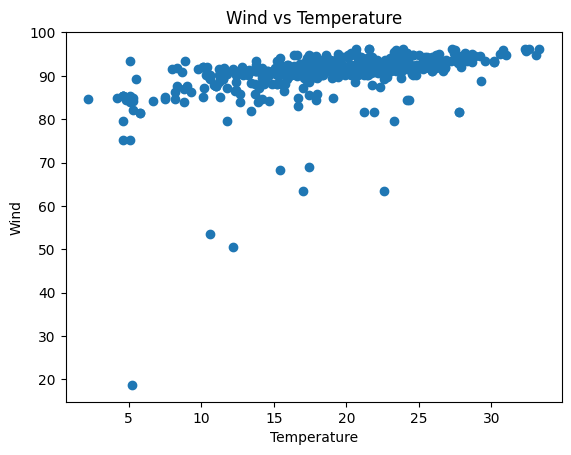

In [5]:
plt.scatter(df['temp'], df['FFMC'])
plt.xlabel('Temperature')
plt.ylabel('Wind')
plt.title("Wind vs Temperature")
plt.show()

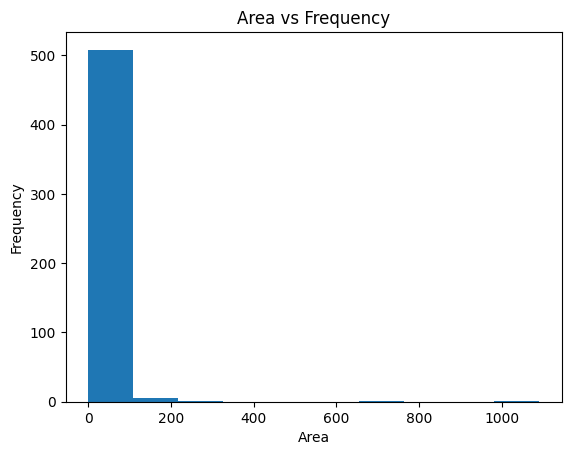

In [6]:
plt.hist(df['area'], bins = 10)
plt.xlabel("Area")
plt.ylabel("Frequency")
plt.title("Area vs Frequency")
plt.show()

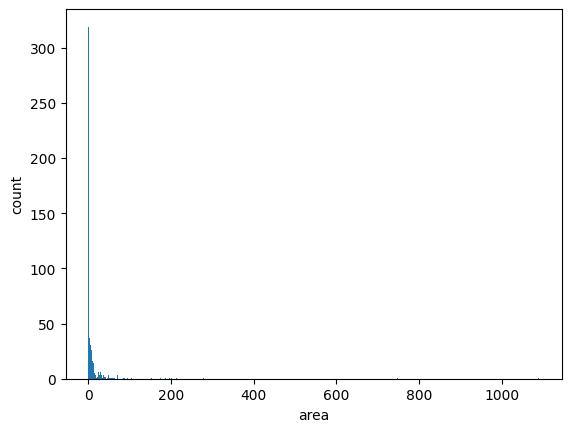

In [7]:
plt.hist(df['area'], bins=500)
plt.xlabel('area')
plt.ylabel('count')
plt.show()

In [45]:
threshold = 0.0
df['goal'] = (df['area'] != threshold).astype(int)
print(len(df.loc[df['goal'] != 0]))

270


In [46]:
df.columns

Index(['X', 'Y', 'month', 'day', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH',
       'wind', 'rain', 'area', 'TempAndFFMC', 'goal', 'season',
       'season_encoded'],
      dtype='object')

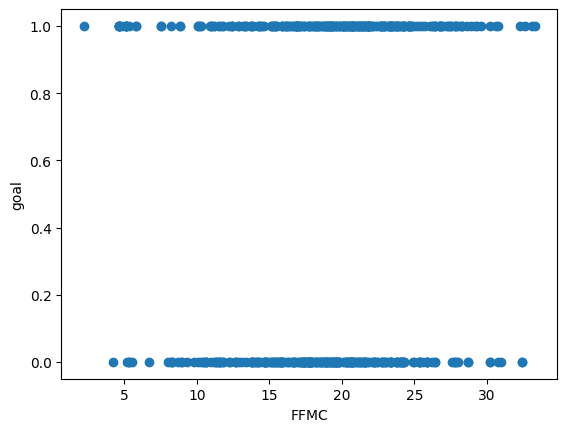

In [47]:
plt.scatter(df['temp'], df['goal'])
plt.xlabel('FFMC')
plt.ylabel('goal')
plt.show()

In [48]:
month_to_season = {
    'jan': 'Winter',
    'feb': 'Winter',
    'mar': 'Spring',
    'apr': 'Spring',
    'may': 'Spring',
    'jun': 'Summer',
    'jul': 'Summer',
    'aug': 'Summer',
    'sep': 'Autumn',
    'oct': 'Autumn',
    'nov': 'Autumn',
    'dec': 'Winter'
}

# Map the months to seasons
df['season'] = df['month'].map(month_to_season)

# Define one-hot encoding vectors for each season
season_vectors = {
    'Spring': [1, 0, 0, 0],
    'Summer': [0, 1, 0, 0],
    'Autumn': [0, 0, 1, 0], 
    'Winter': [0, 0, 0, 1]
}

# Create the season_encoded column with vectors
df['season_encoded'] = df['season'].map(season_vectors)

df.head(2)

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,TempAndFFMC,goal,season,season_encoded
0,7,5,mar,5,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0,0.095128,0,Spring,"[1, 0, 0, 0]"
1,7,4,oct,2,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0,0.198675,0,Autumn,"[0, 0, 1, 0]"


In [49]:
print(len(df))
print(len(df) / 7)

517
73.85714285714286


In [50]:
#season_encoded_df = pd.DataFrame(df['season_encoded'].tolist())
X = pd.concat([df[['ISI', 'temp', 'DC', 'ISI', 'RH', 'wind','TempAndFFMC']]], axis=1).values # , season_encoded_df
Y = df['goal']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.15)
print(X_test.shape)

(78, 7)


# DL Model

In [60]:
inputs = ls.Input(shape=(7, ))

x = ls.Dense(30, activation='relu')(inputs)
x = ls.BatchNormalization()(x)
x = ls.Dense(20, activation='relu')(x)
x = ls.Dense(10, activation='relu')(x)
x = ls.Dense(5, activation='relu')(x)

prediction = ls.Dense(1, activation='sigmoid')(x)

model2 = keras.Model(inputs=inputs, outputs=prediction, name="forest_area_predictor")

model2.summary()

Model: "forest_area_predictor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 7)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 64)             │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,521 (13.75 KB)

 Trainable params: 3,393 (13.25 KB)

 Non-trainable params: 128 (512.00 B)

In [61]:
model2.compile(
    loss=keras.losses.binary_crossentropy,
    optimizer=keras.optimizers.Adam(),
    metrics=["accuracy"],
    #oijsfcn
)

In [62]:
#X_train, X_test, y_train, y_test = train_test_split(df[['ISI', 'temp', 'DC', 'ISI', 'RH', 'wind','TempAndFFMC']], df['goal'])
#X_train = X_train.to_numpy()  # or use .values
#y_train = y_train.to_numpy()  # or use .values

In [63]:
history = model2.fit(X_train, y_train, batch_size=8, epochs=150)
predictions = model2.predict(X_test)

Epoch 1/150


55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4839 - loss: 0.7099
Epoch 2/150
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5240 - loss: 0.6949
Epoch 3/150
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5466 - loss: 0.6863
Epoch 4/150
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5762 - loss: 0.6823
Epoch 5/150
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5531 - loss: 0.6887
Epoch 6/150
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5557 - loss: 0.6798
Epoch 7/150
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5913 - loss: 0.6784
Epoch 8/150
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5763 - loss: 0.6767
Epoch 9/150
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5987 - loss: 0.6653
Epoch 10/150
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5185 - loss: 0.7063
Epoch 11/150
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6021 - loss: 0.6848
Epoch 12/150
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5822 - lo

In [55]:
predictions = predictions.flatten()
print(predictions)

[0.5610187  0.56305134 0.5610187  0.5610187  0.5610187  0.56117225
 0.5610187  0.5610187  0.5610187  0.5610187  0.5610187  0.2207297
 0.5610187  0.5610187  0.5610187  0.5610187  0.5610187  0.02639704
 0.5630339  0.5610187  0.5610187  0.5610187  0.5610187  0.5610187
 0.5610187  0.5610187  0.5610187  0.5610187  0.5610187  0.5610187
 0.5610187  0.5610187  0.5610187  0.5610187  0.56172067 0.56227475
 0.5610187  0.5610187  0.5610187  0.5610187  0.5610187  0.5610187
 0.5610187  0.5610187  0.5610187  0.5610187  0.2207297  0.5610187
 0.5610187  0.5610187  0.5610187  0.1714077  0.5610187  0.5610187
 0.5610187  0.5610187  0.5610187  0.9924571  0.5610187  0.5610187
 0.9932738  0.8671116  0.5610187  0.5610187  0.5610187  0.5610187
 0.5610187  0.5610187  0.5610187  0.5610187  0.5610187  0.99878114
 0.5610187  0.56293404 0.5610187  0.5610187  0.25651938 0.5610187 ]


In [56]:
joblib.dump(model2, 'model3.joblib')

['model3.joblib']

In [57]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

prediction = log_reg.predict(X_test)

In [58]:
print(prediction.flatten())
print([i for i in y_test])
print(np.mean(prediction == y_test))

[1 0 1 0 1 0 0 1 1 1 0 0 1 1 1 1 1 0 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1
 0 1 0 0 1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 1 1 0 1 1 1 1 1 1 1 1 1 0 1 0
 1 1 0 1]
[1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0]
0.5


In [188]:
model_xgb = xgb.XGBClassifier(objective='binary:logistic', n_estimators=200, max_depth=40, learning_rate=0.4)

model_xgb.fit(X_train, y_train)

predictions_xgb = model_xgb.predict(X_test)

print(predictions_xgb)
print([i for i in y_test])
print(np.mean(predictions_xgb == y_test))

[1 0 1 1 0 0 1 0 0 1 0 1 1 0 0 1 0 0 1 1 1 1 0 1 0 0 1 0 1 1 1 0 1 1 0 0 0
 0 1 0 1 0 0 0 0 1 1 0 1 1 0 1 1 0 0 1 1 1 0 1 1 1 0 0 1 0 0 1 0 1 1 0 1 0
 0 0 1 1]
[1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1]
0.5256410256410257


In [189]:
joblib.dump(model_xgb, "xgb.joblib")

['xgb.joblib']

In [192]:
model_rf = RandomForestClassifier(max_depth=30, n_estimators=100)
model_rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=30)

In [193]:
predictions_rf = model_rf.predict(X_test)
print(predictions_rf)
print([i for i in y_test])
print(np.mean(predictions_rf == y_test))

[1 0 1 0 1 0 1 1 0 1 1 1 0 1 0 1 0 0 1 1 1 0 0 1 0 1 1 0 1 1 1 0 1 1 0 0 0
 0 1 0 1 0 0 0 0 1 1 1 1 1 0 0 1 0 0 1 1 1 0 1 1 0 0 1 1 0 0 0 0 0 1 0 1 0
 0 0 1 1]
[1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1]
0.5


In [198]:
base_models = [
    ('rf', model_rf),
    ('xgb', model_xgb),
    ('logreg', log_reg)
]

# Define meta-model
meta_model = LogisticRegression()

# Create stacking model
voting_model = VotingClassifier(
    estimators=base_models,
    voting='hard'
)

votes = voting_model.fit(X_train, y_train)

predictions = voting_model.predict(X_test)

accuracy = np.mean(predictions == y_test)

c:\Users\lordw\OneDrive\Documents\Hackathons\HowdyHack2024\tamuhack24\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [199]:
print(accuracy)

0.5256410256410257
